# Data loading 
Next cells are used to load the data we need.

In [19]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../../')


In [20]:
#data which contains users (row), items(col) and implicit interaction (data)
dataset = pd.read_csv('../data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


# Data pre-processing
Pre-processing of data to check for missing users, items ecc...

In [21]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [22]:
ICM_df = pd.read_csv('../data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [23]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [24]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

#splitting data into train and validation (from the previous training data)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)

In [25]:
URM_all

<7947x25975 sparse matrix of type '<class 'numpy.float64'>'
	with 113268 stored elements in Compressed Sparse Row format>

In [26]:
ICM_all

<25975x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 490691 stored elements in Compressed Sparse Row format>

In [27]:
#evaluator for validation (used for hyperparameter tuning)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

In [28]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

recommender = ItemKNNCBFRecommender(URM_train, ICM_all)

ItemKNNCBFRecommender: URM Detected 54 (0.68 %) cold users.
ItemKNNCBFRecommender: URM Detected 1994 (7.68 %) cold items.


In [29]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [30]:
items_per_feature

array([ 5,  3,  2, ...,  6, 75, 17], dtype=int32)

In [31]:
argsort_features  = np.argsort(items_per_feature)
argsort_features

array([ 7294, 11584,  7172, ..., 11253,  3398, 11565], dtype=int64)

In [46]:
from GraphBased.RP3betaRecommender import RP3betaRecommender

map_list = []
selection_quota_list = [0.1, 0.3, 0.5, 0.7, 0.9]

for selection_quota in selection_quota_list:
    
    n_to_select = int(selection_quota*len(argsort_features))
    selected_features = argsort_features[n_to_select:]
    
    ICM_selected = ICM_all[:,selected_features]
    
    print("Selected {}/{} features".format(n_to_select, len(argsort_features)))
    
    recommender_beta_ICM = RP3betaRecommender(ICM_selected.T)
    recommender_beta_ICM.fit(topK=70, alpha=0.35, beta=0.4, implicit=False)
    recommender_beta_ICM.URM_train = URM_train
    
    results_dict, _ = evaluator_validation.evaluateRecommender(recommender_beta_ICM)
    map_list.append(results_dict[10]["MAP"])

Selected 2000/20000 features
RP3betaRecommender: URM Detected 27 (0.10 %) cold items.
EvaluatorHoldout: Processed 4955 ( 100.00% ) in 8.10 sec. Users per second: 611
Selected 6000/20000 features
RP3betaRecommender: URM Detected 32 (0.12 %) cold items.
RP3betaRecommender: Processed 24800 ( 95.48% ) in 1.01 minutes. Rows per second: 411
EvaluatorHoldout: Processed 4955 ( 100.00% ) in 11.32 sec. Users per second: 438
Selected 10000/20000 features
RP3betaRecommender: URM Detected 47 (0.18 %) cold items.
EvaluatorHoldout: Processed 4955 ( 100.00% ) in 5.99 sec. Users per second: 828
Selected 14000/20000 features
RP3betaRecommender: URM Detected 74 (0.28 %) cold items.
EvaluatorHoldout: Processed 4955 ( 100.00% ) in 8.67 sec. Users per second: 572
Selected 18000/20000 features
RP3betaRecommender: URM Detected 195 (0.75 %) cold items.
EvaluatorHoldout: Processed 4955 ( 100.00% ) in 6.18 sec. Users per second: 801


No handles with labels found to put in legend.


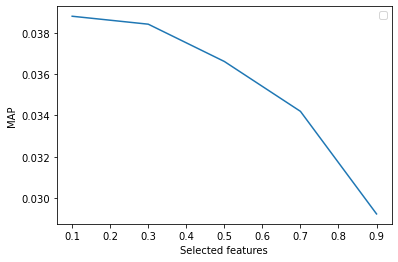

In [47]:
plt.plot(selection_quota_list, map_list)
plt.ylabel('MAP')
plt.xlabel('Selected features')
plt.legend()
plt.show()

In [ ]:
x_tick = []
collaborative_MAP = []

for topK in [500,600, 625, 650, 700]:
    for shrink in [150,190,200,250,300,400,500]:
        x_tick.append("topk {}, shrink{}".format(topK,shrink))


        recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
        recommender.fit(topK=topK, shrink=shrink, feature_weighting = 'TF-IDF')

        result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

        collaborative_MAP.append(result_dict[10]["MAP"])

In [ ]:
import operator
index, value = max(enumerate(collaborative_MAP), key=operator.itemgetter(1))
print(index, value)
parameters = x_tick[index]
print(parameters)

In [ ]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(20, 9))
plt.plot(x_tick, collaborative_MAP, label="Collaborative")
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.ylabel('MAP')
plt.xlabel('TopK')
plt.xticks(rotation='vertical')
plt.show()

In [12]:
test_users = pd.read_csv('data_target_users_test.csv')
test_users

,user_id
0,0
1,1
2,2
3,3
4,4
...,...
7939,7942
7940,7943
7941,7944
7942,7945


In [20]:
# best model itemCBF topk 600, shrink200, weightTF-IDF

recommender = ItemKNNCBFRecommender(URM_all, ICM_all)
recommender.fit(topK=600, shrink=200, feature_weighting = 'TF-IDF')

user_id = test_users['user_id']
recommendations, scores = recommender.recommend(user_id, cutoff = 10, return_scores = True)



ItemKNNCBFRecommender: URM Detected 1079 (4.15 %) cold items.
Similarity column 25975 ( 100 % ), 3593.63 column/sec, elapsed time 0.12 min


In [43]:
scores

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.02475152],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00432772, 0.243365  , ..., 0.27803853, 0.06369334,
        0.01637073],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00470511, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [45]:
print(scores.max(axis=1).mean())
print(scores.max(axis=1).std())


0.5016902
0.52792645


In [28]:
recommendations

[[13884, 23417, 15968, 10698, 16510, 10223, 7908, 13272, 22445, 25734],
 [12119, 6198, 10179, 5115, 10829, 9142, 7768, 20310, 22393, 25619],
 [14353, 5593, 8877, 4401, 16333, 1565, 18003, 22865, 21613, 5923],
 [519, 16086, 13592, 825, 12157, 10689, 8561, 13209, 17510, 11338],
 [13864, 5191, 7704, 867, 6397, 12587, 9023, 10234, 14259, 11638],
 [16172, 22517, 15150, 17819, 9301, 19152, 15146, 25285, 16615, 14706],
 [24801, 10355, 426, 3569, 8041, 11215, 10239, 19037, 17590, 21470],
 [17332, 4314, 13840, 4228, 8104, 20620, 13360, 14682, 11300, 12181],
 [1014, 14059, 13345, 4044, 11991, 18148, 23857, 8310, 12050, 9316],
 [15782, 5741, 17092, 3699, 5045, 12375, 25779, 660, 1376, 11024],
 [3556, 12906, 24567, 1302, 4462, 14968, 10045, 11944, 4413, 21303],
 [4661, 3220, 16175, 14310, 13119, 21262, 15586, 9416, 18960, 16320],
 [6235, 9054, 7322, 3998, 19135, 13774, 4113, 479, 17585, 24675],
 [3067, 18028, 21966, 12123, 10278, 13631, 25743, 23339, 2026, 5257],
 [20644, 3641, 555, 21541, 18499, 

In [16]:
print(recommender.W_sparse.mean())

0.0005752755


In [ ]:
for index in range(len(recommendations)):
    #print(element)
    recommendations[index]=np.array(recommendations[index])
    #print(type(element))
print(len(recommendations))

In [ ]:
test_users['item_list']= recommendations
#test_users['item_list'] =  test_users['item_list'].apply(lambda x: x.replace('[','').replace(']','')) 
test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])

#convert the string columns to int
#test_users['item_list'] = test_users['item_list'].astype(int)
test_users
test_users.to_csv('submission.csv', index=False)
